Podemos implementar um stacked autoencoder de fomra muito similar a uma MLP

In [157]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [158]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [159]:
#reincia o grafo sempre para o mesmo estado
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)

In [160]:
reset_graph()

In [161]:
n_inputs =28*28 #dimensoes do mnist
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [162]:
learning_rate = 0.01
l2_reg = 0.001

In [163]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [164]:
with tf.contrib.framework.arg_scope(
        [fully_connected],
        activation_fn = tf.nn.elu,
        weights_initializer = tf.contrib.layers.variance_scaling_initializer(),
        weights_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)):
    hidden1 = fully_connected(X, n_hidden1, scope='hidden1')
    hidden2 = fully_connected(hidden1, n_hidden2, scope='hidden2')
    hidden3 = fully_connected(hidden2, n_hidden3, scope='hidden3')
    ouputs = fully_connected(hidden3, n_outputs, activation_fn=None, scope='outputs')

Utilizamos a MSE como loss

In [165]:
reconstruction_loss = tf.reduce_mean(tf.square(ouputs - X))

e adicionamos a regularização

In [166]:
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses) 

In [167]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [168]:
init = tf.global_variables_initializer()

Agora podemos treinar nosso autoencoder. Note que as labels dos dígitos (y_batch) não são usadas

In [169]:
n_epochs = 10
batch_size = 150
saver = tf.train.Saver()

In [170]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):            
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        print('training loss: ', loss.eval(feed_dict={X: mnist.train.images}))
    save_path = saver.save(sess, "./my_mnist_autoencoder.ckpt")

training loss:  0.0862613
training loss:  0.0567132
training loss:  0.0550036
training loss:  0.0549723
training loss:  0.0545715
training loss:  0.0545841
training loss:  0.0547248
training loss:  0.0547999
training loss:  0.0545833
training loss:  0.054632


Podemos enviar uma imagem para nosso autoencoder e ver como ele a reconstroi

In [171]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [172]:
test_img = mnist.test.images[0]

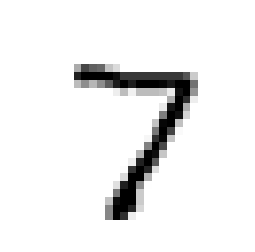

In [173]:
plt.imshow(test_img.reshape(28, 28), cmap="binary", interpolation="nearest")
plt.axis("off")
plt.show()

In [174]:
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_autoencoder.ckpt")
    reconstructed_img = ouputs.eval(feed_dict={X: [test_img]})

INFO:tensorflow:Restoring parameters from ./my_mnist_autoencoder.ckpt


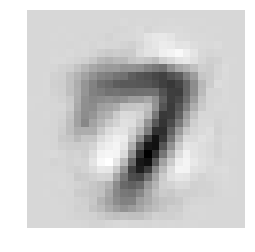

In [175]:
plt.imshow(reconstructed_img.reshape(28, 28), cmap="binary", interpolation="nearest")
plt.axis("off")
plt.show()

Podemos visualizar as features aprendidas pelo modelo. Abaixo vamos plotar as features aprendidas por 25 dos 300 neurônios da primeira camada

In [239]:
def get_weights():
    return [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('weights:0')] #obtem apenas os weights, ignorando bias

In [226]:
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_autoencoder.ckpt")
    weights = sess.run(get_weights())

INFO:tensorflow:Restoring parameters from ./my_mnist_autoencoder.ckpt


In [227]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis="off"

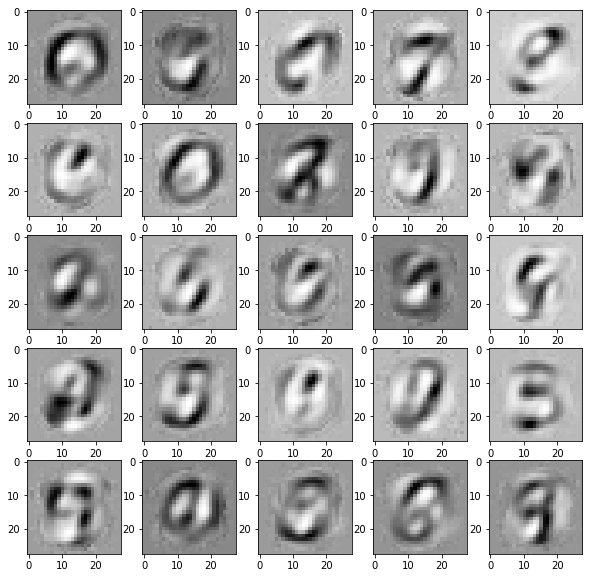

In [238]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plot_image(weights[0].T[i])
plt.show()

In [229]:
weights[0].shape

(784, 300)

In [220]:
weights[0]

array([[ -1.01557863e-33,  -1.14659188e-33,   3.99889219e-34, ...,
         -3.11224539e-07,  -4.83505806e-34,  -4.14671297e-10],
       [  1.18107060e-34,  -6.71526127e-33,   4.45742286e-32, ...,
          8.49825110e-34,  -1.25079505e-33,  -1.67259571e-13],
       [ -2.77228588e-34,  -7.17399528e-21,  -3.57895679e-14, ...,
          2.81664786e-32,  -9.63752499e-17,  -3.66820726e-34],
       ..., 
       [ -8.60826268e-34,   6.98292134e-34,  -5.67077209e-34, ...,
          3.62327399e-34,   8.22506034e-33,   1.25935912e-05],
       [  6.40363111e-33,   9.23095143e-34,  -5.09341680e-10, ...,
          9.93548396e-34,  -7.30916510e-34,  -7.30222234e-34],
       [  2.12144404e-34,  -1.25448757e-33,   1.05727929e-33, ...,
          1.13722743e-21,  -1.24158505e-33,   1.26293644e-33]], dtype=float32)